In [1]:
# initializing
library(tidyverse)
library(scales)
library(tidymodels)
library(dplyr)

# reading/wrangling the data
players_data <- read_csv("data/players.csv") |>
    mutate(subscribe = as_factor(subscribe)) |>
    select(subscribe, played_hours, Age)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    

→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 29 rows.
               ✖ Assigned data has 30 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 30 to size 29.

There were issues with some computations   A: x1

→ B | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 28 rows.
               ✖ Assigned data has 29 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 29 to size 28.

There were issues with some computations   A: x1
There were issues with some computations   A: x1   B: x1

There were issues with some computations   A: x1   B: x1





[1] 19

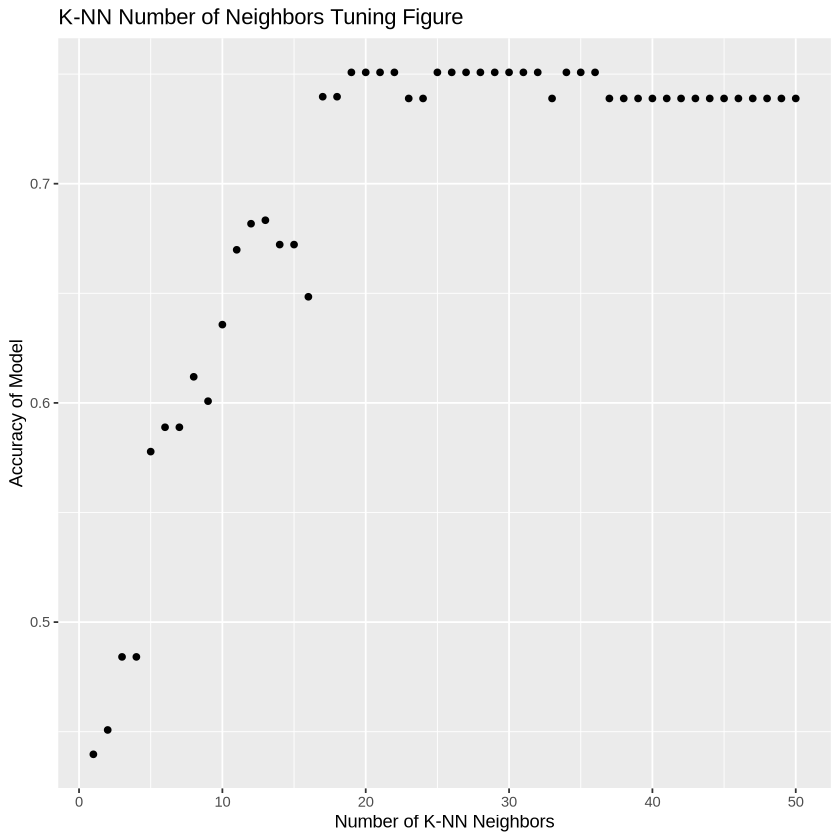

In [2]:
# finding optimal neighbors
set.seed(1)

players_split <- initial_split(players_data, prop = 0.75, strata = subscribe)
players_training <- training(players_split)
players_testing <- testing(players_split)

players_recipe <- recipe(subscribe ~ played_hours + Age, data = players_data) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

vfold <- vfold_cv(players_training, v = 5, strata = subscribe)
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    tune_grid(resamples = vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

k_neighbors_plot <- ggplot(players_fit, aes(x = neighbors, y = mean)) +
    geom_point() +
    labs(y = "Accuracy of Model", x = "Number of K-NN Neighbors") +
    ggtitle("K-NN Number of Neighbors Tuning Figure")
k_neighbors_plot

neighbors_best <- players_fit |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
neighbors_best

In [3]:
# using the optimal neighbors model

players_spec_optimal <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
  set_engine("kknn") |>
  set_mode("classification")

players_fit_optimal <- workflow() |>
    add_model(players_spec_optimal) |>
    add_recipe(players_recipe) |>
    fit(data = test) |>
    predict(test) |>
    bind_cols(test)

# gathering metrics

players_fit_accuracy <- players_fit_optimal |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

players_fit_precision <- players_fit_optimal |>
    precision(truth = subscribe, estimate = .pred_class, event_level="second")

players_fit_recall <- players_fit_optimal |>
    recall(truth = subscribe, estimate = .pred_class, event_level="second")

print(players_fit_accuracy)
print(players_fit_precision)
print(players_fit_recall)

ERROR: Error in eval(expr, envir, enclos): object 'test' not found
